# Ensemble Learning and Random Forests

Aggregate predictions from multiple models to achieve better results than any single model

In [1]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression()
svm_clf = SVC()
rnd_clf = RandomForestClassifier()

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting='hard' #pure majority voting
)
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFo...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [4]:
from sklearn.metrics import accuracy_score

print("Hard voting:")
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

Hard voting:
LogisticRegression 0.824
RandomForestClassifier 0.896
SVC 0.888
VotingClassifier 0.872


In [5]:
log_clf = LogisticRegression()
svm_clf = SVC(probability=True)
rnd_clf = RandomForestClassifier()

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting='soft' #weighted by model confidence
)
voting_clf.fit(X_train, y_train)

print("Soft voting:")
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

Soft voting:
LogisticRegression 0.824
RandomForestClassifier 0.88
SVC 0.888
VotingClassifier 0.88


## Bagging Ensembles

Instead of training different algorithms, we can train the same algorithm on different training subsets of the data. When sampling is performed with replacement, this procedure is called bagging, and without replacement is called pasting. In Scikit-Learn, this is denoted by the bootstrap option (true=bagging, false=pasting).

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True, 
    n_jobs=2,
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print("Bagging Accuracy: ", accuracy_score(y_pred, y_test))

Bagging Accuracy:  0.904


How does this compare to a single Decision Tree?

In [7]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("Single Decision Tree Accuracy: ", accuracy_score(y_pred_tree, y_test))

Single Decision Tree Accuracy:  0.88


In [8]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, cmap="Set2", alpha=0.3)
    if contour:
        plt.contour(x1, x2, y_pred, cmap="Set2", alpha=0.8)
    plt.plot(X[:,0][y==0],X[:,1][y==0], "ro", alpha=alpha)
    plt.plot(X[:,0][y==1],X[:,1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$y_1$", fontsize=18)

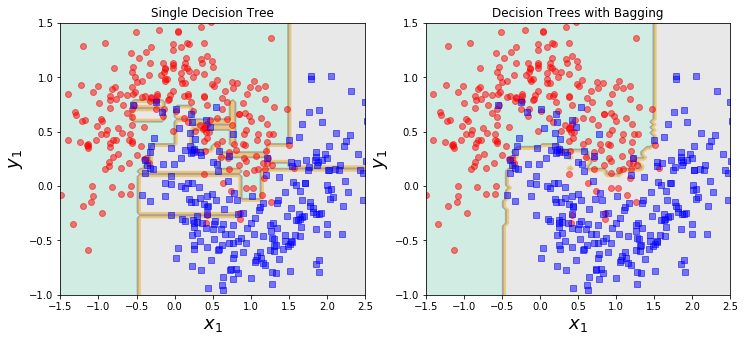

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Single Decision Tree")
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging")
plt.show()


#### Out-of-Bag Evaluation

When using bagging, we can check the ensemble model accuracy by testing on the out-of-bag instances, i.e. instances which were not used when training each predictor.  This essentially gives us a validation set for free, meaning that the training sets can be bigger.

In [10]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    n_jobs=2,
    oob_score=True
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=2, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [11]:
y_pred = bag_clf.predict(X_test)
print("Out of Bag Accuracy: ", bag_clf.oob_score_)
print("Test Accuracy: ", accuracy_score(y_pred, y_test))

Out of Bag Accuracy:  0.8906666666666667
Test Accuracy:  0.896


## Random Forests

An ensemble of Decision Trees, generally trained via the bagging method -- exactly what we just did above.  Scikit-Learn has it's own RandomForestClassifier(or Regressor) that is more convenient and optimized containing both DecisionTree and Bagging hyperparameters

In [12]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 100, max_leaf_nodes=16, n_jobs=2)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print("Random Forest Accuracy: ", accuracy_score(y_pred, y_test))

Random Forest Accuracy:  0.912


If we also wanted the Random Forest algorithm to use random thresholds for each feature rather than searching for the best possible threshold, we can use Extra-Trees (Extremely Random Trees).  These are much faster to train and reduces model variance, but produces larger bias.

In [13]:
from sklearn.ensemble import ExtraTreesClassifier

xtree_clf = ExtraTreesClassifier(n_estimators=100, max_leaf_nodes=16)
xtree_clf.fit(X_train, y_train)
y_pred = xtree_clf.predict(X_test)
print("Random Forest Accuracy: ", accuracy_score(y_pred, y_test))

Random Forest Accuracy:  0.888


#### Feature Importance
Random Forests also have the ability to measure the relative importance of each feature by looking at how much the tree nodes that use that feature reduce impurity accross all trees in the forest.  Let's look at feature importances for the iris dataset:

In [14]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=2)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10305792217634283
sepal width (cm) 0.023611051555934164
petal length (cm) 0.4251994903775883
petal width (cm) 0.4481315358901346


Looks like petal length and width are much more important for classification compared to sepal length and width

## Boosting

Using an Ensemble method to combine several weak learners into a strong learner

### AdaBoost
Train subsequent models on the instances the predecessor underfitted to focus new predictors more and more on the hard cases.  A first base estimator is trained and used to make predictions on the training set, then the relative weight of misclassified training instances are increased.  The next classifier is trained using the updated weights, again makes predictions on the training set, and then updates the weights accordingly. This process continues for a set number of iterations or until a threshold is reached.

In [15]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=None)

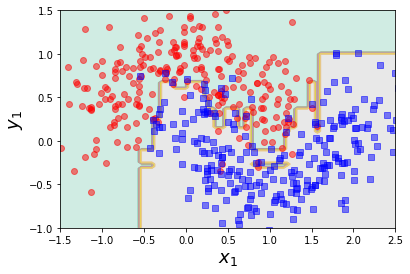

In [16]:
plot_decision_boundary(ada_clf, X, y)

### Gradient Boosting
Just like AdaBoost, Gradient Boosting works by adding subsequent models that correct the previous model's shortcomings.  However, instead of adjusting the instance weights, Gradient Boosting fits subsequent models on the previous model's residual error.

We will first do this manually to show the procedure and then use Scikit-Learn's built in GradientBoostingRegressor

In [17]:
# Generating quadratic data
X = np.random.rand(100,1) - 0.5
y = 3*X[:,0]**2 + 0.05 * np.random.randn(100)

In [18]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [19]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [20]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [21]:
def plot_predictions(regressors, X, y, axes=[-0.5,0.5,-0.1,0.8], label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1,1)) for regressor in regressors)
    plt.plot(X[:,0],y , data_style, label=data_label)
    plt.plot(x1, y_pred, style, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=12)
    plt.axis(axes)

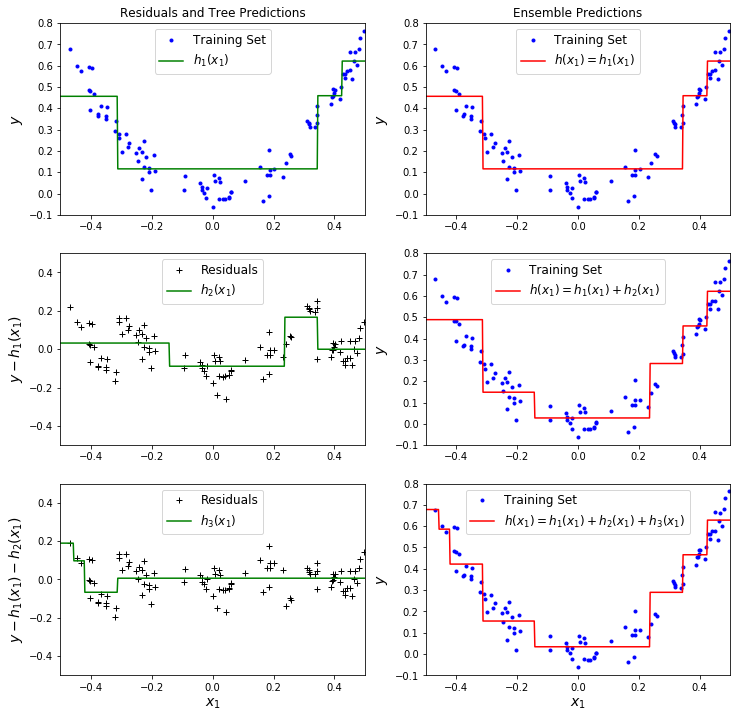

In [22]:
plt.figure(figsize=(12,12))

plt.subplot(321)
regressors = [tree_reg1]
plot_predictions(regressors, X, y, label="$h_1(x_1)$", style="g-", data_label="Training Set")
plt.ylabel("$y$", fontsize=14)
plt.title("Residuals and Tree Predictions")

plt.subplot(322)
plot_predictions(regressors, X, y, label="$h(x_1) = h_1(x_1)$", data_label="Training Set")
plt.ylabel("$y$", fontsize=14)
plt.title("Ensemble Predictions")

plt.subplot(323)
regressors = [tree_reg2]
plot_predictions(regressors, X, y2, axes=[-0.5,0.5,-0.5,0.5], label="$h_2(x_1)$", style="g-", data_label="Residuals", data_style="k+")
plt.ylabel("$y - h_1(x_1)$", fontsize=14)

plt.subplot(324)
regressors = [tree_reg1, tree_reg2]
plot_predictions(regressors, X, y, label="$h(x_1) = h_1(x_1) + h_2(x_1)$", data_label="Training Set")
plt.ylabel("$y$", fontsize=14)

plt.subplot(325)
regressors = [tree_reg3]
plot_predictions(regressors, X, y3,axes=[-0.5,0.5,-0.5,0.5], label="$h_3(x_1)$", style="g-", data_label="Residuals", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=14)
plt.xlabel("$x_1$", fontsize=14)

plt.subplot(326)
regressors = [tree_reg1, tree_reg2, tree_reg3]
plot_predictions(regressors, X, y, label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$", data_label="Training Set")
plt.ylabel("$y$", fontsize=14)
plt.xlabel("$x_1$", fontsize=14)

plt.show()


In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
%time gbrt.fit(X,y)

CPU times: user 1.85 ms, sys: 1 ms, total: 2.85 ms
Wall time: 3.13 ms


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1)
%time gbrt_slow.fit(X,y)

CPU times: user 65.2 ms, sys: 5.05 ms, total: 70.3 ms
Wall time: 283 ms


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

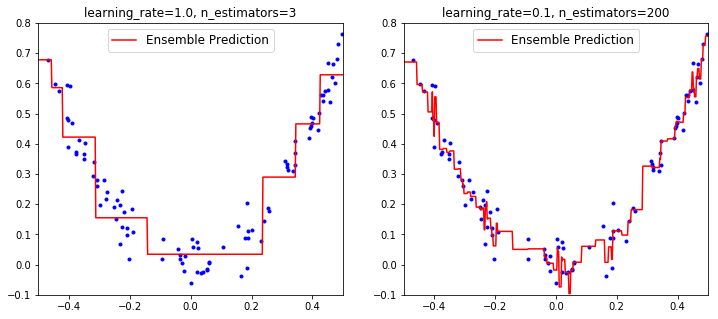

In [25]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plot_predictions([gbrt], X, y, label="Ensemble Prediction")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators))

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, label="Ensemble Prediction")
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators))
plt.show()



#### Gradient Boosting with Early Stopping

In [26]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=62, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

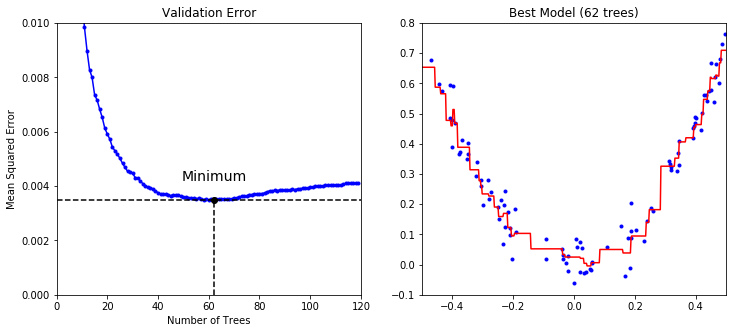

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(errors,"b.-")
plt.plot([best_n_estimators, best_n_estimators], [0,np.min(errors)], "k--")
plt.plot([0,120], [np.min(errors),np.min(errors)], "k--")
plt.plot(best_n_estimators, np.min(errors), "ko")
plt.text(best_n_estimators, np.min(errors)*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0,120,0,.01])
plt.xlabel("Number of Trees")
plt.ylabel("Mean Squared Error")
plt.title("Validation Error")

plt.subplot(122)
plot_predictions([gbrt_best], X, y)
plt.title("Best Model ({} trees)".format(best_n_estimators))
plt.show()

## Ensemble Modeling with MNIST

In [28]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()
X = mnist["data"]
y = mnist["target"]

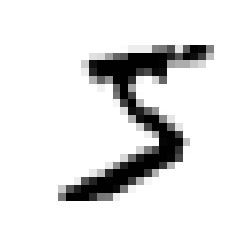

'5'

In [29]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary", interpolation="nearest")
plt.axis("off")
plt.show()
y[0]

In [30]:
X_train, y_train = X[:50000], y[:50000]
X_train_small, y_train_small = X[:5000], y[:5000]
X_val, y_val = X[50000:60000], y[50000:60000]
X_test, y_test = X[60000:], y[60000:]


In [31]:
log_clf = LogisticRegression()
svm_clf = SVC(probability=True, #Using hyperparamters from grid search in ch5-SVM notebook
              kernel="rbf", 
              decision_function_shape="ovr", 
              gamma=0.01329, 
              C=6.432)
rnd_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16)
xtree_clf = ExtraTreesClassifier(n_estimators=200, max_leaf_nodes=16)

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf), ("xf", xtree_clf)],
    n_jobs=3,
    voting='soft' #weighted by model confidence
)

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

vote_pipeline = Pipeline([
    ("std_scale", StandardScaler()),
    ("v_clf", voting_clf)
])

In [41]:
%time vote_pipeline.fit(X_train_small, y_train_small)

CPU times: user 393 ms, sys: 186 ms, total: 579 ms
Wall time: 4min 21s


Pipeline(memory=None,
     steps=[('std_scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('v_clf', VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='...se=0, warm_start=False))],
         flatten_transform=None, n_jobs=3, voting='soft', weights=None))])

In [46]:
for clf in (log_clf, svm_clf, rnd_clf, xtree_clf, voting_clf):
    clf.fit(X_train_small, y_train_small)
    y_pred = clf.predict(X_test[:1000])
    print(clf.__class__.__name__, accuracy_score(y_test[:1000], y_pred))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression 0.794
SVC 0.126
RandomForestClassifier 0.754
ExtraTreesClassifier 0.735
VotingClassifier 0.836


The above displays how to set up a voting classifier with many different models.  By combining the models, a significant gain in performance can be achieved. (We trained on only a small subset of MNIST data to demonstrate the procedure.)

## What did we accomplish?

1. Trained many different models and combined them together with hard and soft voting to make predictions.
2. Instead of training different models, we trained the same model with different training instances in a process called bagging.  Bagging with decision trees results in the common Random Forest algorithm.
3. Used AdaBoost and Gradient Boosting to correct a model by adding subsequent models.
4. Demonstrated how to perform ensemble modeling on MNIST data.